#### Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

START_PERIOD = pd.to_datetime('2020-03-03')  # Первый день начала пандемии

data = pd.read_csv('owid-covid-data.csv')

In [2]:
# Выделим Россию от даты начала пондемии
ru_data = data[data.iso_code == 'RUS']
ru_data = ru_data[ru_data.date >= str(START_PERIOD)]
ru_data['day_num'] = range(1, len(ru_data) + 1)  # начинаем с первого дня начала пандемии

# Для обучения берем первые 50 наблюдений
train = ru_data[:50]
test = ru_data[50:]

# Выделим для теста наблюдения с 51 по 151
X_test_100 = test[:100].day_num
y_test_total_100 = test[:100].total_cases
y_test_new_100 = test[:100].new_cases

X_train = train.day_num
y_train_total = train.total_cases
y_train_new = train.new_cases

full_data = np.hstack([X_train, X_test_100])

#### Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

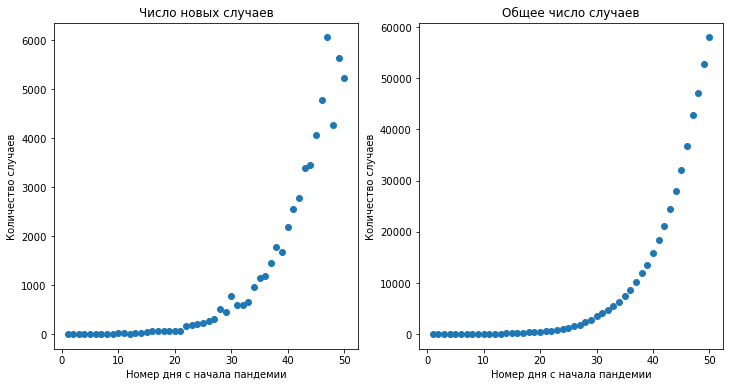

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(train.day_num, train.new_cases)
ax[0].set_title('Число новых случаев')
ax[0].set_xlabel('Номер дня с начала пандемии')
ax[0].set_ylabel('Количество случаев')
ax[1].scatter(train.day_num, train.total_cases)
ax[1].set_title('Общее число случаев')
ax[1].set_xlabel('Номер дня с начала пандемии')
ax[1].set_ylabel('Количество случаев')
plt.show();

По началу рост действительно напоминает экпоненциальный...

#### Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.


Переведем задачу обучения регрессии с экопонентой в задачу нахождения натурального логарифма целевой переменной линейной функцией от номера текущего дня:

\begin{equation}
y\approx e^{f(x)} \Rightarrow ln(y)\approx f(x) \Rightarrow z = f(x),
\end{equation}
где:
f(x) - линейная функция от x,

Тогда,
\begin{equation}
y=e^z
\end{equation}

Обучим такую модель:

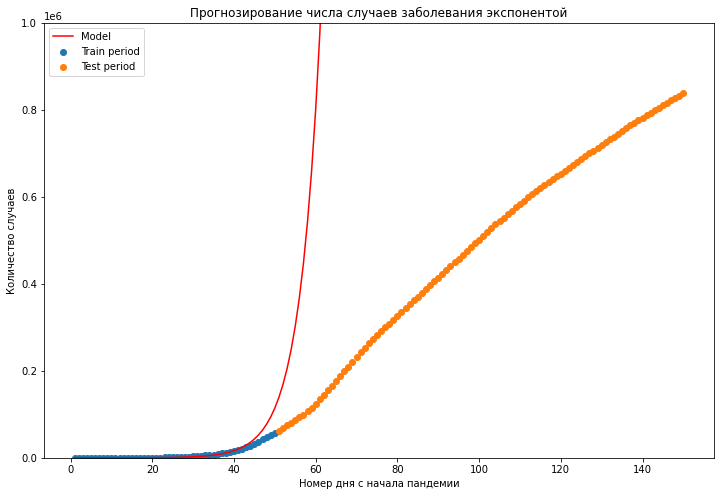

In [4]:
class ExpRegr:
    def __init__(self):
        self.model = linear_model.LinearRegression(fit_intercept=True)

    def fit(self, dates_train, cases):
        X = np.array(dates_train).reshape(-1, 1)
        y = np.array(cases).reshape(-1, 1)
        self.model.fit(X, np.log(y))

    def _predict(self, dates_test):
        X = np.array(dates_test).reshape(-1, 1)
        return self.model.predict(X)

    def predict(self, dates_test):
        return np.exp(self._predict(dates_test))

    def _std_noise(self, dates_train, cases):
        X = np.array(dates_train).reshape(-1, 1)
        y = np.array(cases).reshape(-1, 1)
        return np.exp(np.std(np.log(y) - self._predict(X)))


model = ExpRegr()
model.fit(X_train, y_train_total)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X_train, y_train_total, label='Train period')
ax.scatter(X_test_100, y_test_total_100, label='Test period')
ax.plot(full_data, model.predict(full_data), label='Model', c='red')
ax.set_ylim(0, 1000000)
ax.set_xlabel('Номер дня с начала пандемии')
ax.set_ylabel('Количество случаев')
ax.legend(loc='upper left')
ax.set_title('Прогнозирование числа случаев заболевания экспонентой')
plt.show();

Слабо похоже на правдивый рост...

#### Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).



Предположим априорное распределение параметров модели многомерным нормальным с $\mu_0$ cредним, и $\Sigma_0$ матрицей ковариации.
Апостериорное распределение также - нормальное, с параметрами $\mu_n$ и $\Sigma_n$ и расчитывается по следующим формулам, с использованием параметров априорного распределения:
\begin{equation}
\Sigma_n=(\Sigma_0^{-1}+\frac{1}{\sigma^{2}}X^{T}X)^{-1}
\end{equation}
\begin{equation}
\mu_n=\Sigma_n(\Sigma_0^{-1}\mu_0+\frac{1}{\sigma^{2}}X^{T}y)
\end{equation}


Напишем функцию для расчета параметров апостериорного распределения:

In [5]:
std_noise = model._std_noise(X_train, y_train_total)
mu_0 = np.array([0, 0])
sigma_0 = 2 * np.eye(2)


def bayesian_update(mu_0, sigma_0, X, y, std_noise):
    X = np.vstack([np.ones(X.shape[0]), X]).T
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + (1 / (std_noise ** 2)) * np.matmul(np.transpose(X), X))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma_0), mu_0) + (1 / (std_noise ** 2)) * np.matmul(np.transpose(X), y))
    return mu_n, sigma_n


mu_n, sigma_n = bayesian_update(mu_0, sigma_0, X_train, np.log(y_train_total), std_noise)

#### Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).



Сэмплируем многомерное нормальное распределение с найденными параметрами:

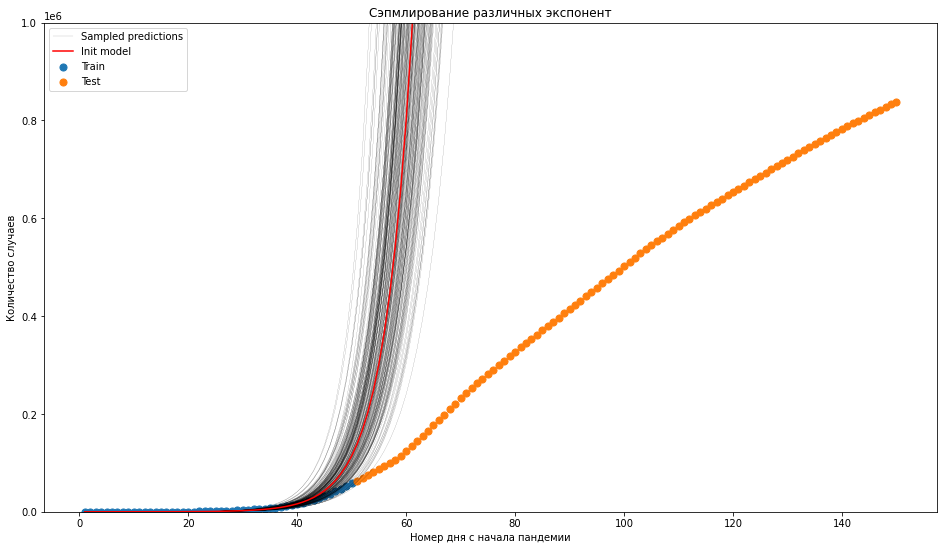

In [6]:
def sample_exps(model, mu_n, sigma_n, n_iter, X_train, X_test, y_train, y_test):
    full_data = np.hstack([X_train, X_test])
    W = np.random.multivariate_normal(mu_n, sigma_n, n_iter)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_ylim((0, 1000000))
    for w in W:
        ax.plot(full_data, np.exp(w[0] + w[1] * full_data), 'k-', lw=.1, label='Sampled predictions')
    ax.scatter(X_train, y_train, s=50, c='tab:blue', label='Train')
    ax.scatter(X_test, y_test, s=50, c='tab:orange', label='Test')
    ax.plot(full_data, model.predict(full_data), c='red', label='Init model')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[-4:], labels=labels[-4:], loc='upper left')
    ax.set_xlabel('Номер дня с начала пандемии')
    ax.set_ylabel('Количество случаев')
    ax.set_title('Сэпмлирование различных экспонент')
    plt.plot()


sample_exps(model, mu_n, sigma_n, 200, X_train, X_test_100, y_train_total, y_test_total_100)

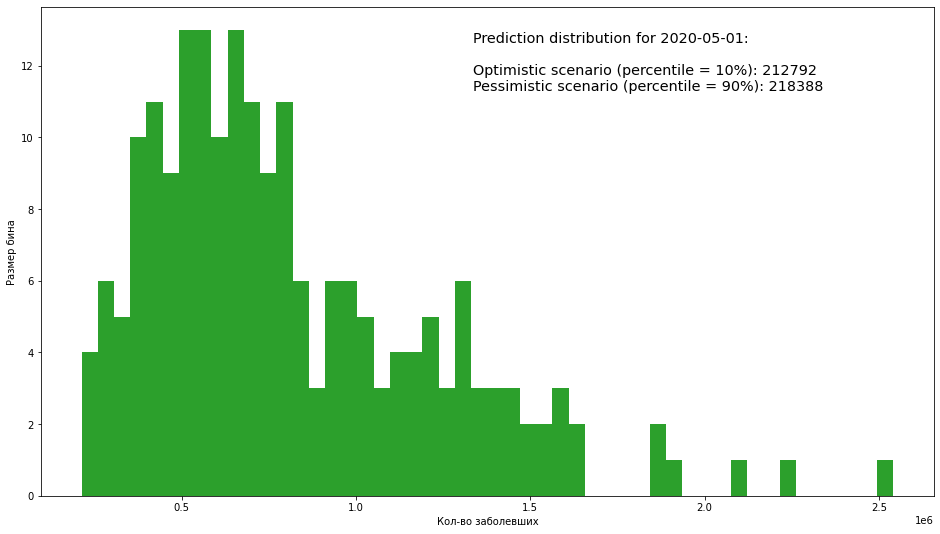

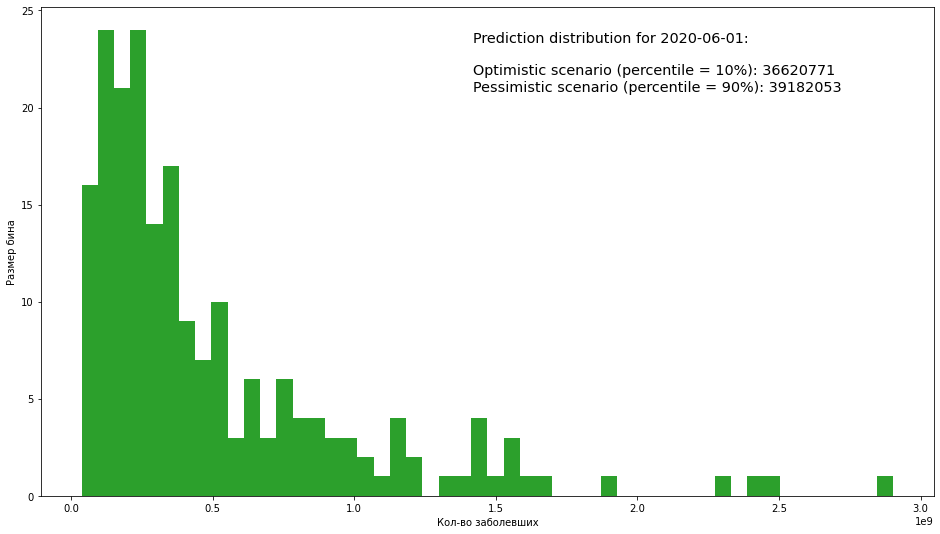

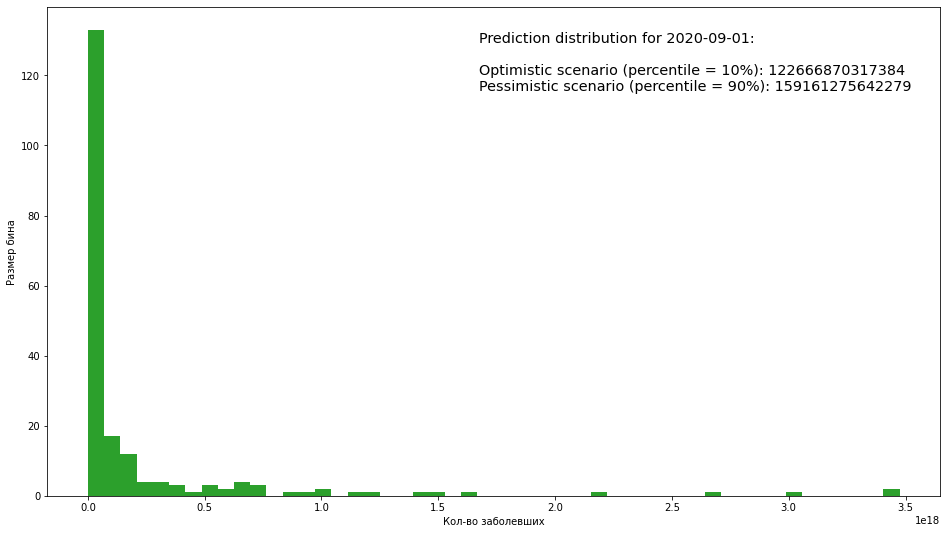

In [7]:
def sample_exps_by_dates(dates, mu_n, sigma_n, n_iter):
    W = np.random.multivariate_normal(mu_n, sigma_n, n_iter)
    for date in dates:
        days = date.day_of_year - START_PERIOD.day_of_year
        prediction = np.exp(W[:, 0] + W[:, 1] * days)
        report_string = f'Prediction distribution for {date.date()}:\n\n' \
                        f'Optimistic scenario (percentile = 10%): {int(np.percentile(prediction, 0.1))}\n' \
                        f'Pessimistic scenario (percentile = 90%): {int(np.percentile(prediction, 0.9))}'
        plt.figure(figsize=(16, 9))
        plt.hist(prediction, bins=n_iter // 4, color='tab:green')
        plt.xlabel('Кол-во заболевших')
        plt.ylabel('Размер бина')
        plt.figtext(0.50, 0.75, report_string, fontsize='x-large')


sample_exps_by_dates([pd.to_datetime('2020-05-01'),
                      pd.to_datetime('2020-06-01'),
                      pd.to_datetime('2020-09-01')],
                     mu_n, sigma_n, n_iter=200)

Даже в самом оптимистичном случае - получается очень пессимистично :(

#### Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
\begin{equation}
\Phi(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^x e^{-t^{2}/2}  dt
\end{equation}

#### Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

#### Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.


Число заболевших обновляется ежедневно, таким образом, целевая переменная представляет собой ступенчатую функцию. И так как каждое последующее наблюдение отличается предыдущего на какую-то константсу, то логичнее всего:
>Взять в качестве целевой переменной - новые случаи заболевания
>Вместо интеграла, использовать скользящую сумму (np.cumsum), для прогнрзирования общего числа заболевших

Таким образом задача выглядит следующий образом:

\begin{equation}
y=\int_{i}^{j} e^{f(x^2)}dt \Rightarrow e^{f(x^2)} * [\Delta = 1 \text{ (разница в наблюдениях составляет 1 день)}]
\end{equation}

Таким образом задача снова сводится к обучению экпоненциальной регресии от квадратичной функции Х, а это делать мы умеем :)

#### Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

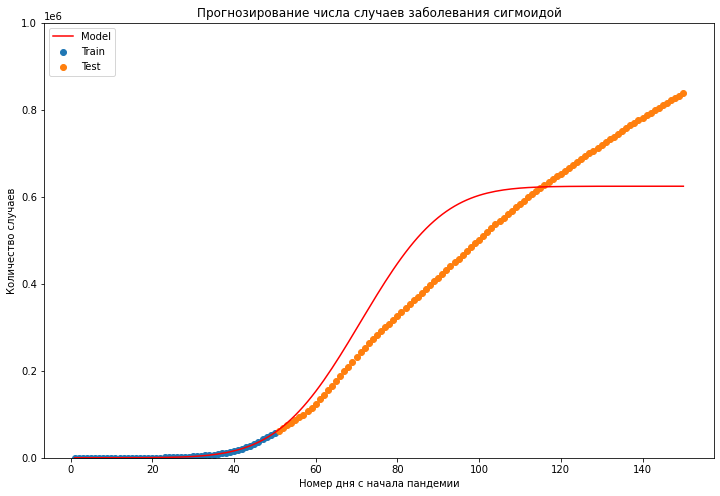

In [8]:
class SigmoidRegr:
    def __init__(self):
        self.model = linear_model.LinearRegression(fit_intercept=True)

    def _process_data(self, X):
        X = np.array(X).reshape(-1, 1)
        X = np.hstack([X, X ** 2])
        return X

    def fit(self, dates_train, cases):
        X = self._process_data(dates_train)
        y = np.array(cases).reshape(-1, 1)
        self.model.fit(X, np.log(y))

    def _predict(self, dates_test):
        return self.model.predict(self._process_data(dates_test))

    def predict(self, dates_test):
        return np.exp(self._predict(dates_test))

    def predict_total(self, dates_test):
        return np.cumsum(self.predict(dates_test))

    def _std_noise(self, dates_train, cases):
        y = np.array(cases).reshape(-1, 1)
        return np.std(np.log(y) - self._predict(dates_train))


model = SigmoidRegr()

# Для исключения нулей под логарифмом
zero_to_one = lambda x: 1 if x == 0 else x
y_train_new = y_train_new.apply(zero_to_one)
y_test_new_100 = y_test_new_100.apply(zero_to_one)

model.fit(X_train, y_train_new)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X_train, y_train_total, label='Train')
ax.scatter(X_test_100, y_test_total_100, label='Test')
ax.plot(full_data, model.predict_total(full_data), c='red', label='Model')
ax.set_ylim(0, 1000000)
ax.set_xlabel('Номер дня с начала пандемии')
ax.set_ylabel('Количество случаев')
ax.legend(loc='upper left')
ax.set_title('Прогнозирование числа случаев заболевания сигмоидой')
plt.plot();

Формулы для расчета остались прежними

In [9]:
sigma_noise_sigm = model._std_noise(X_train, y_train_new)
mu_0_sigm = np.array([0, 0, 0])
sigma_0_sigm = 2 * np.eye(3)


def bayesian_step_sigmoid(mu_0, sigma_0, X, y, std_noise):
    X = np.vstack([np.ones(X.shape[0]), X, X ** 2]).T
    sigma_n = np.linalg.inv(np.linalg.inv(sigma_0) + (1 / (std_noise ** 2)) * np.matmul(np.transpose(X), X))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma_0), mu_0) + (1 / (std_noise ** 2)) * np.matmul(np.transpose(X), y))
    return mu_n, sigma_n


mu_n_sigm, sigma_n_sigm = bayesian_step_sigmoid(mu_0_sigm, sigma_0_sigm, X_train, np.log(y_train_new), sigma_noise_sigm)

#### Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

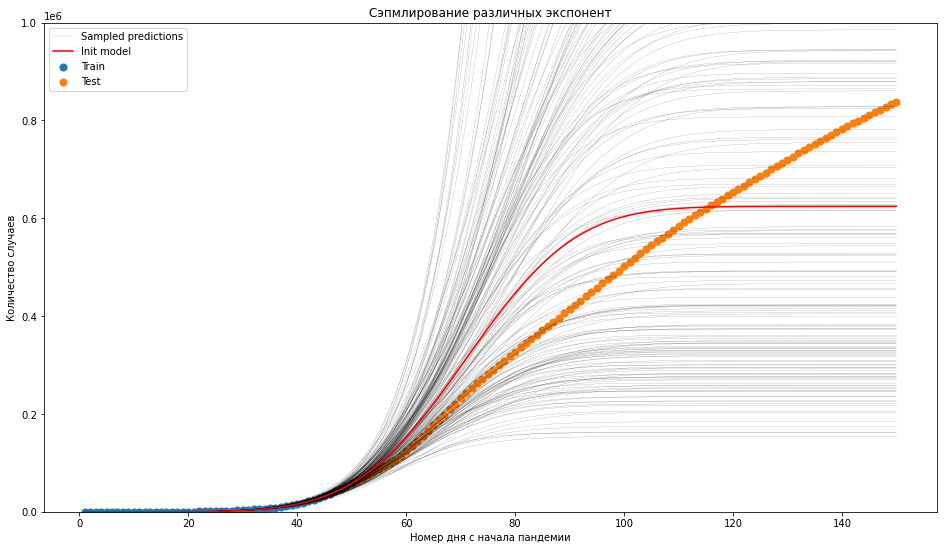

In [10]:
def sample_sigm(model, mu_n, sigma_n, n_iter, X_train, X_test, y_train, y_test):
    full_data = np.hstack([X_train, X_test])
    W = np.random.multivariate_normal(mu_n, sigma_n, n_iter)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.set_ylim((0, 1000000))
    for w in W:
        ax.plot(full_data, np.cumsum(np.exp(w[0] + w[1] * full_data + w[2] * full_data ** 2)), 'k-', lw=.1,
                label='Sampled predictions')
    ax.scatter(X_train, y_train, s=50, c='tab:blue', label='Train')
    ax.scatter(X_test, y_test, s=50, c='tab:orange', label='Test')
    ax.plot(full_data, model.predict_total(full_data), c='red', label='Init model')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[-4:], labels=labels[-4:], loc='upper left')
    ax.set_xlabel('Номер дня с начала пандемии')
    ax.set_ylabel('Количество случаев')
    ax.set_title('Сэпмлирование различных экспонент')
    plt.plot()


sample_sigm(model, mu_n_sigm, sigma_n_sigm, 200, X_train, X_test_100, y_train_total, y_test_total_100)

<Figure size 1152x648 with 0 Axes>

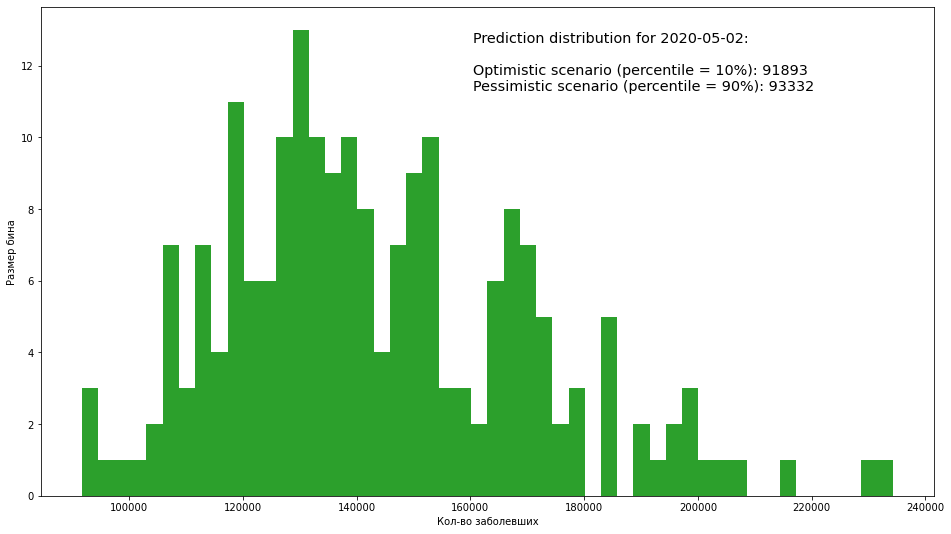

<Figure size 1152x648 with 0 Axes>

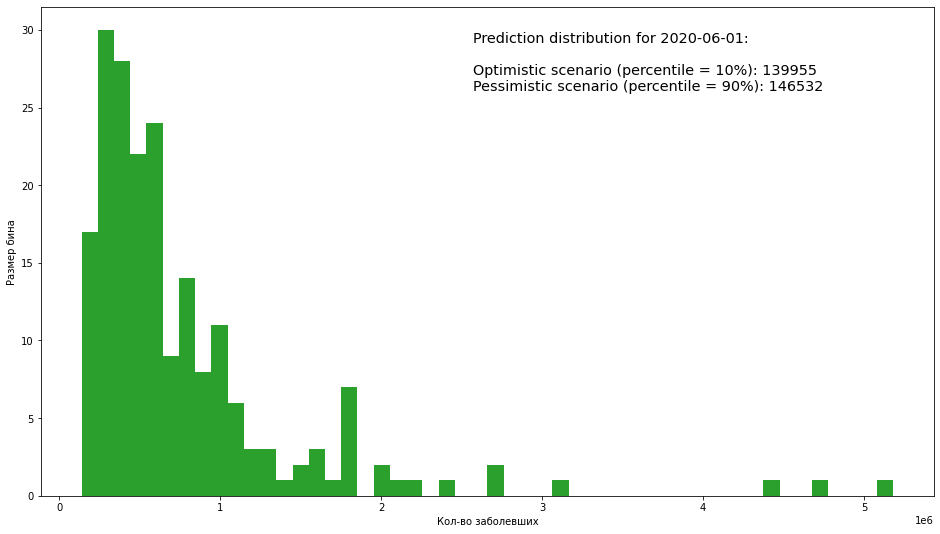

<Figure size 1152x648 with 0 Axes>

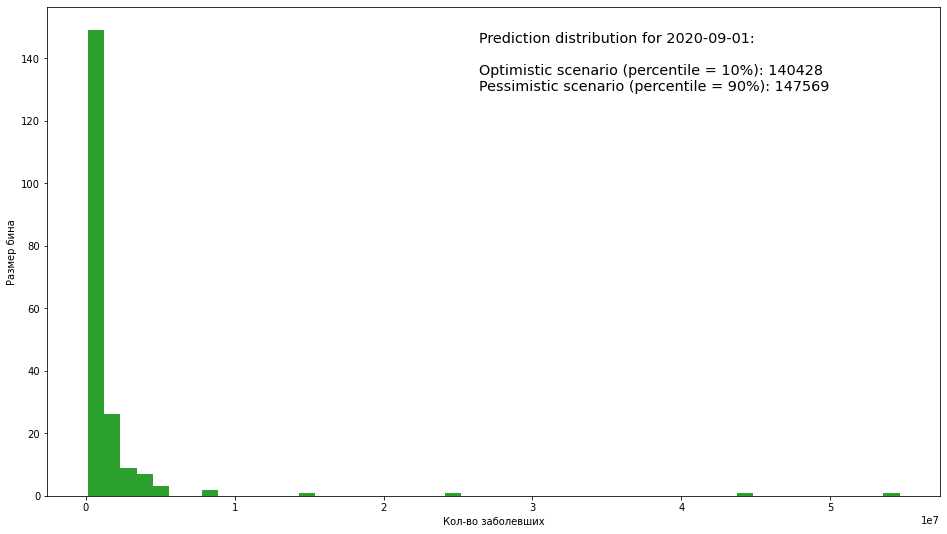

In [11]:
def sample_sigmoid_by_dates(dates, mu_n, sigma_n, n_iter, new_cases_train):
    W = np.random.multivariate_normal(mu_n, sigma_n, n_iter)
    for date in dates:
        #берем все точки после 50-ой, для подсчета total c помощью cumsum
        days = np.arange(51, date.day_of_year - START_PERIOD.day_of_year)
        prediction = list()
        for w in W:
            new_cases = np.append(new_cases_train, np.exp(w[0] + w[1] * days + w[2] * days ** 2))
            prediction.append(np.cumsum(new_cases)[-1])
        plt.figure(figsize=(16, 9))
        report_string = f'Prediction distribution for {date.date()}:\n\n'\
                        f'Optimistic scenario (percentile = 10%): {int(np.percentile(prediction, 0.1))}\n'\
                        f'Pessimistic scenario (percentile = 90%): {int(np.percentile(prediction, 0.9))}'
        plt.figure(figsize=(16, 9))
        plt.hist(prediction, bins=n_iter // 4, color='tab:green')
        plt.xlabel('Кол-во заболевших')
        plt.ylabel('Размер бина')
        plt.figtext(0.50, 0.75, report_string, fontsize='x-large')
        plt.show()


sample_sigmoid_by_dates([pd.to_datetime('2020-05-02'),
                         pd.to_datetime('2020-06-01'),
                         pd.to_datetime('2020-09-01')],
                        mu_n_sigm, sigma_n_sigm, 200, y_train_new);

#### Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?

Рано или поздно, что логично, у роста заболеваемости происходит "насыщение" - рост заболеваемости, даже при очень сильной заразностти вируса, резко сокращатся в определенный момент. Это может быть связано как с общим количеством людей, проживающий в России, так как нелья заразить больше людей, чем проживает, а также с выработкой общего иммунитета. Однако, "сигмоидальное" поведение вируса, справделиво только для начала пандемии, и так как вирус меняется и мутирует, а люди вакцинируются, то рост заболеваемости меняет свое распределение на нечто другое (возможно это несколько подряд идущих сигмоид, с плавными падениями в точке соедининий).
Банально, но скорее всего, карантин стоит вводить в начале экспоненциального роста сигмоиды, и не отменять до точки насыщения, и отменять, постепенно снимая ограничения, чтобы не допустить повторного экспоненциального роста.

P.S: очень крутое задание, спасибо :) Было бы время, решил бы и бонусное